In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
def create_test_catalog():
    num_sources = 2
    indices = np.arange(num_sources)

    dims = ("index", "power")
    catalog = xr.Dataset(
        {
            "logpolycoefflux": (dims, np.zeros((len(indices), 5), dtype=np.float64)),
            "logpolycoefpolflux": (dims, np.zeros((len(indices), 5), dtype=np.float64)),
        },
        coords={
            "index": indices,
            "power": np.arange(5)[::-1],
            "theta": ("index", np.array([np.pi / 4, np.pi / 2])),
            "phi": ("index", np.zeros(num_sources)),
        },
    )
    for field in ["theta", "phi"]:
        catalog[field].attrs["units"] = "rad"
    for field in ["logpolycoefflux", "logpolycoefpolflux"]:
        catalog[field].attrs["units"] = "Jy"
    catalog["logpolycoefflux"].loc[dict(index=0, power=0)] = 3.7
    catalog["logpolycoefflux"].loc[dict(index=1, power=1)] = 2
    fn = "test_catalog.h5"
    catalog.to_netcdf(str(fn), format="NETCDF4")  # requires netcdf4 package
    return str(fn)

In [9]:
test_catalog = create_test_catalog()

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from pysm3.models.catalog import PointSourceCatalog
from pysm3 import utils

In [12]:
import h5py
from pixell import enmap
from pysm3 import units as u
import healpy as hp

In [13]:
from pysm3.utils import car_aperture_photometry

from numpy.testing import assert_allclose

In [15]:
catalog = PointSourceCatalog(test_catalog, nside=nside)
freqs = np.exp(np.array([3, 4])) * u.GHz  # ~ 20 and ~ 55 GHz
weights = np.array([1, 1], dtype=np.float64)
weights /= np.trapz(weights, x=freqs.to_value(u.GHz))

scaling_factor = utils.bandpass_unit_conversion(
    freqs, weights, output_unit=u.uK_RJ, input_unit=u.Jy / u.sr
) / (hp.nside2pixarea(nside) * u.sr)
fluxes_I = catalog.get_fluxes(freqs, weights=weights)

fwhm = 5 * u.deg
output_map = catalog.get_emission(
    freqs, weights=weights, output_units=u.uK_RJ, fwhm=fwhm, return_car=True
)
with h5py.File(test_catalog) as f:
    pix = np.round(
        enmap.sky2pix(
            output_map.shape,
            output_map.wcs,
            np.column_stack((np.pi / 2 - np.array(f["theta"]), f["phi"])),
        )
    ).astype(int)
assert_allclose(
    output_map[0].argmax(unit="coord"), np.array([0, 0]), atol=1e-2, rtol=1e-3
)

box_half_size_rad = 2 * fwhm.to_value(u.rad)
box_center = [0, 0]
box = np.array(
    [
        [box_center[0] - box_half_size_rad, box_center[1] - box_half_size_rad],
        [box_center[0] + box_half_size_rad, box_center[1] + box_half_size_rad],
    ]
)  # in radians
cutout = output_map[0].submap(box)
flux = car_aperture_photometry(cutout, 2 * fwhm.to_value(u.rad))
#assert_allclose(flux, surface_brigthness[0].to_value(u.uK_RJ), rtol=1e-3)

In [19]:
hp.mollview(output_map_no_beam[0], title="No beam")

NameError: name 'output_map_no_beam' is not defined

In [180]:
output_map.max()

array(15.242674, dtype=float32)

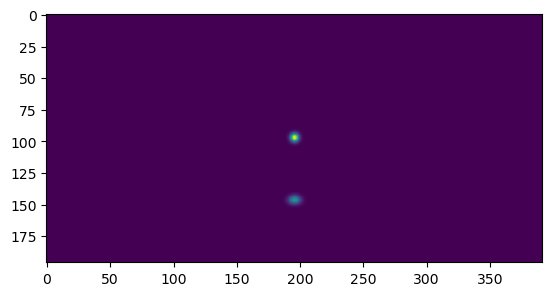

In [192]:
plt.imshow(output_map[0])

In [182]:
from pixell import pointsrcs, enmap, enplot

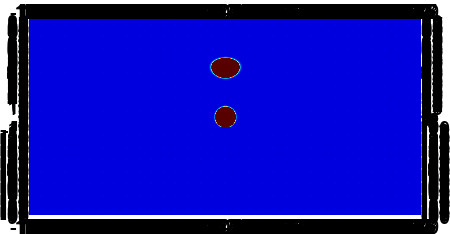

In [183]:
enplot.pshow(output_map[0])

In [184]:
output_map[0].max()

array(15.242674, dtype=float32)

In [185]:
output_map[0].argmax(unit="coord")

array([-0.00801427,  0.        ])

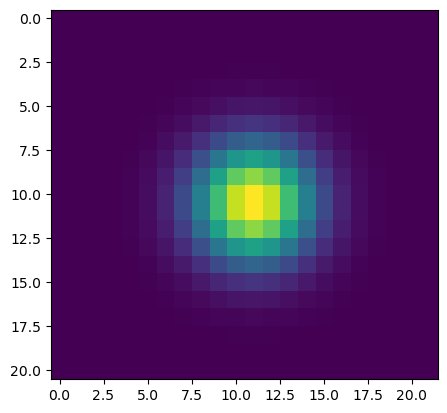

In [186]:
plt.imshow(cutout)


In [194]:
cutout.max(), cutout.min()

(array(15.242674, dtype=float32), array(0., dtype=float32))

In [195]:
car_aperture_photometry(cutout, 2 * fwhm.to_value(u.rad))

0.1345646071749576

ndmap([[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.19125725e-04 3.30663373e-04 7.62350915e-04
  1.45983545e-03 2.32190988e-03 3.06737539e-03 3.36569222e-03
  3.06737539e-03 2.32190988e-03 1.45983545e-03 7.62350915e-04
  3.30663373e-04 1.19125725e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.90603969e-04 6.38177095e-04 1.77423458e-03 4.09587799e-03
  7.85121322e-03 1.24965338e-02 1.65157858e-02 1.81246921e-02
  1.65157858e-02 1.24965338e-02 7.85121322e-03 4.09587799e-03
  1.77423458e-03 6.38177095e-04 1.90603969e-04 0.00000000e+0

In [20]:
output_map = catalog.get_emission(
    freqs, weights=weights, output_units=u.uK_RJ, fwhm=fwhm, return_car=False
)

In [21]:
from pysm3 import utils
utils.healpix_aperture_photometry(output_map[0], nside, 0, 0, 2 * fwhm.to_value(u.rad))

8.458601032601701e-09

In [39]:
aperture_radius = 2 * fwhm.to_value(u.rad)
theta=np.pi/2
phi=0
m = output_map[0]

In [40]:
nside = hp.npix2nside(len(m))

In [41]:
annulus_width = (np.sqrt(2.0) - 1.0) * aperture_radius
ipix_aperture_radius = hp.query_disc(
    nside, hp.ang2vec(theta, phi), aperture_radius, inclusive=True
)
ipix_total = hp.query_disc(
    nside, hp.ang2vec(theta, phi), aperture_radius + annulus_width, inclusive=True
)
ipix_annulus = np.array(list(set(ipix_total).difference(set(ipix_aperture_radius))))
# mean background level from the annulus
mean = np.mean(m[ipix_annulus])
flux = np.sum(m[ipix_aperture_radius] - mean) * hp.nside2pixarea(nside)

In [43]:
m[ipix_annulus] = hp.UNSEEN

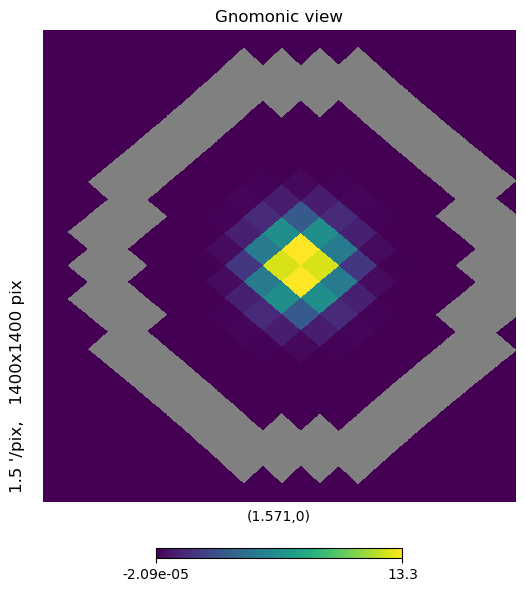

In [44]:
hp.gnomview(m, rot=(theta, phi), xsize=1400, ysize=1400)

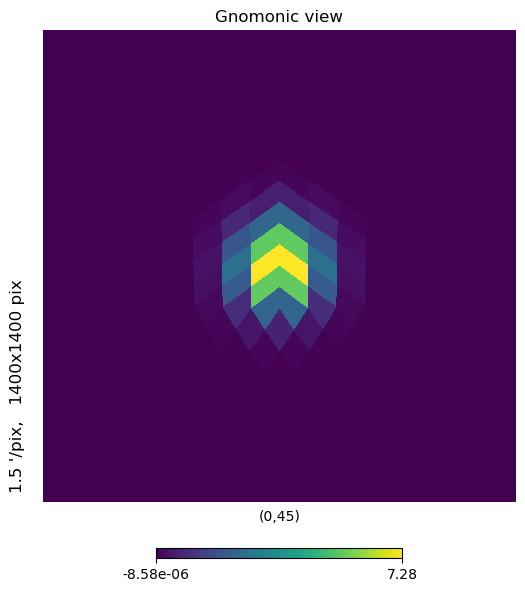

In [51]:

hp.gnomview(m, rot=(0, 45), xsize=1400, ysize=1400)

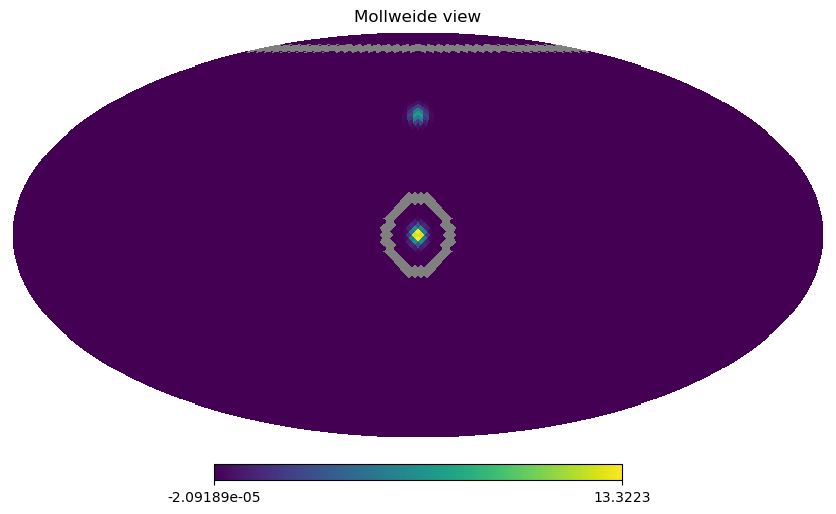

In [45]:
hp.mollview(m)